### Bibliotecas

In [1]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from torchvision import utils, datasets, transforms

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

### Parâmetros

In [2]:
torch.manual_seed(42)
np.random.seed(42)

GAN_TYPE = 'WGAN_GP'
print(f"Executando com o modo: {GAN_TYPE}")

image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
ngpu = 1
num_epochs = 5
real_label_val = 0.9 
fake_label_val = 0.1

if GAN_TYPE == 'DCGAN':
    lr = 0.0001
    beta1 = 0.5
    n_critic = 1
    clip_value = None
    lambda_gp = None
    
elif GAN_TYPE == 'WGAN_CP':
    lr = 0.00005
    beta1 = 0.0
    beta2 = 0.9
    n_critic = 5
    clip_value = 0.01
    lambda_gp = None
    
elif GAN_TYPE == 'WGAN_GP':
    lr = 0.001
    beta1 = 0.0
    beta2 = 0.9
    n_critic = 5
    clip_value = None
    lambda_gp = 2.0
    
dataroot = '../data'
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

Executando com o modo: WGAN_GP


### Dataloader

In [96]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.CIFAR10(root=dataroot, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

### Pesos

In [97]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Arquitetura da rede

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input é Z, indo para um ConvTransposed (nz x 1 x 1)
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input é (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        return self.main(input)

netG = Generator(ngpu).to(device)
netD = Discriminator(ngpu).to(device)

netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

### Cálculo de penalidade

In [99]:
def calculate_gradient_penalty(netD, real_data, fake_data, device, lambda_gp):
    alpha = torch.rand(real_data.size(0), 1, 1, 1, device=device)
    alpha = alpha.expand_as(real_data)
    interpolates = (alpha * real_data + ((1 - alpha) * fake_data)).requires_grad_(True)

    disc_interpolates = netD(interpolates).view(-1, 1)

    gradients = torch.autograd.grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(disc_interpolates, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)

    gradient_penalty = lambda_gp * ((gradient_norm - 1) ** 2).mean()
    return gradient_penalty

### Otimizadores

In [100]:
if GAN_TYPE == 'WGAN_CP':
    optimizerD = optim.RMSprop(netD.parameters(), lr=lr)
    optimizerG = optim.RMSprop(netG.parameters(), lr=lr)
else:
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))

if GAN_TYPE == 'DCGAN':
    criterion = nn.BCEWithLogitsLoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

### Treinamento

Ponto importante aqui pessoal.

É possível que a perda do Discriminador fique negativa, mas é devido a natureza da função de perda WGAN. Aqui não usamos a entropia cruzada binária, que tem limites de ${0}$ a $\infty$. Usamos a distância de wasserstein, que é uma métrica real para a diferença entre as distribuições de dados reais ($\mathbb{P}_r$) e falsos ($\mathbb{P}_g$).

O objetivo do Crítico é maximizar a distância de wasserstein, que é calculada como:

$$L_D = \mathbb{E}_{x \sim \mathbb{P}_r}[D(x)] - \mathbb{E}_{z \sim \mathbb{P}_z}[D(G(z))]$$

Onde:
* $\mathbb{E}[D(x)]$ é a pontuação média do Crítico para imagens **Reais**.
* $\mathbb{E}[D(G(z))]$ é a pontuação média do Crítico para imagens **Falsas**.

Para maximizar essa diferença, o Crítico tenta dar uma pontuação **alta** para as reais e **baixa** para as falsas.

A atualização dos pesos do Crítico usa a minimização, então a perda implementada é, na verdade, o negativo do valor que o Crítico está tentando maximizar:

$$\text{Loss\_D} = -\left( \mathbb{E}[D(x)] - \mathbb{E}[D(G(z))] \right) = \mathbb{E}[D(G(z))] - \mathbb{E}[D(x)]$$

- Se o Crítico estiver indo muito bem ($D(x) \approx 1$ e $D(G(z)) \approx -1$), a diferença será um número negativo grande (ex: $D(G(z)) - D(x) \approx -1 - 1 = -2$).
- Quanto mais negativa for a `Loss_D`, melhor o Crítico está estimando a distância e melhor está o treinamento.

O Gerador ($G$) tenta minimizar a mesma distância, que é calculada como o oposto da perda do Crítico, focando apenas no termo dos *fakes*:

$$\text{Loss\_G} = -\mathbb{E}_{z \sim \mathbb{P}_z}[D(G(z))]$$

In [101]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training...")

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        
        output_real = netD(real_cpu).view(-1)
        
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        output_fake = netD(fake.detach()).view(-1)

        if GAN_TYPE == 'DCGAN':
            label_real = torch.full((b_size,), real_label_val, dtype=torch.float, device=device)
            label_fake = torch.full((b_size,), fake_label_val, dtype=torch.float, device=device)
            errD_real = criterion(output_real, label_real)
            errD_fake = criterion(output_fake, label_fake)
            errD = errD_real + errD_fake
            
        else:
            errD = output_fake.mean() - output_real.mean()
            
            if GAN_TYPE == 'WGAN_GP':
                gp = calculate_gradient_penalty(netD, real_cpu.data, fake.data, device, lambda_gp)
                errD += gp
        
        errD.backward()
        optimizerD.step()

        if GAN_TYPE == 'WGAN_CP':
            for p in netD.parameters():
                p.data.clamp_(-clip_value, clip_value)
                
        if i % n_critic == 0:
            netG.zero_grad()
            output_fake = netD(fake).view(-1)
            
            if GAN_TYPE == 'DCGAN':
                label_real_for_G = torch.full((b_size,), real_label_val, dtype=torch.float, device=device)
                errG = criterion(output_fake, label_real_for_G)
                
            else:
                errG = -output_fake.mean()

            errG.backward()
            optimizerG.step()
        
        if i % 50 == 0 or (len(dataloader)-1) == i:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] '
                  f'Loss_D: {errD.item():.4f} '
                  f'Loss_G: {errG.item():.4f}')
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
                
        iters += 1

print("Completed")

Starting Training...
[0/5][0/391] Loss_D: 70.5152 Loss_G: 4.4530
[0/5][50/391] Loss_D: -29.0964 Loss_G: 33.1046
[0/5][100/391] Loss_D: -70.8708 Loss_G: -35.5188
[0/5][150/391] Loss_D: -86.1598 Loss_G: -2.5659
[0/5][200/391] Loss_D: -54.0310 Loss_G: 40.7453
[0/5][250/391] Loss_D: -67.2232 Loss_G: 54.3374
[0/5][300/391] Loss_D: -52.3364 Loss_G: -3.0523
[0/5][350/391] Loss_D: -54.6003 Loss_G: 3.6813
[0/5][390/391] Loss_D: -37.9070 Loss_G: -8.5664
[1/5][0/391] Loss_D: 1.6321 Loss_G: -46.1649
[1/5][50/391] Loss_D: -44.0105 Loss_G: -16.7710
[1/5][100/391] Loss_D: -33.2637 Loss_G: -32.9287
[1/5][150/391] Loss_D: -35.6101 Loss_G: -19.2876
[1/5][200/391] Loss_D: -29.4014 Loss_G: -26.6565
[1/5][250/391] Loss_D: -22.7185 Loss_G: -25.6502
[1/5][300/391] Loss_D: -22.3081 Loss_G: -38.0400
[1/5][350/391] Loss_D: -16.4805 Loss_G: -45.9721
[1/5][390/391] Loss_D: -15.2541 Loss_G: -31.2035
[2/5][0/391] Loss_D: -8.2049 Loss_G: -44.8291
[2/5][50/391] Loss_D: -21.8463 Loss_G: -23.3690
[2/5][100/391] Loss_D:

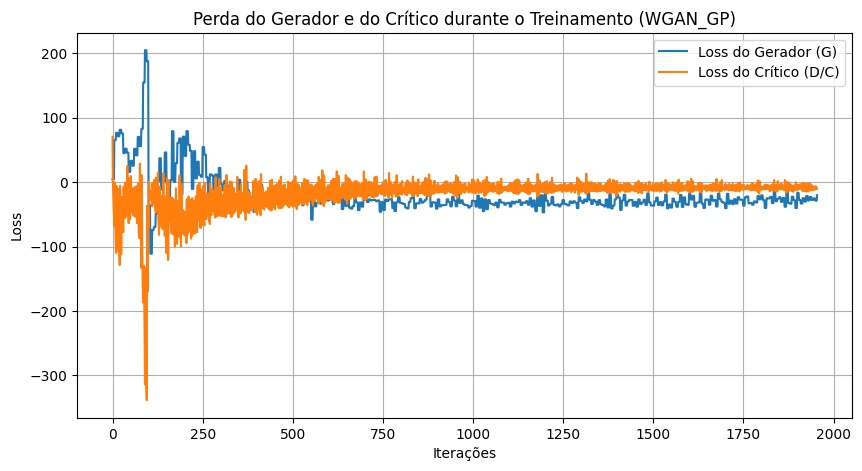

In [106]:
plt.figure(figsize=(10,5))
plt.title(f"Perda do Gerador e do Crítico durante o Treinamento ({GAN_TYPE})")
plt.plot(G_losses, label="Loss do Gerador (G)")
plt.plot(D_losses, label="Loss do Crítico (D/C)")

plt.xlabel("Iterações")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

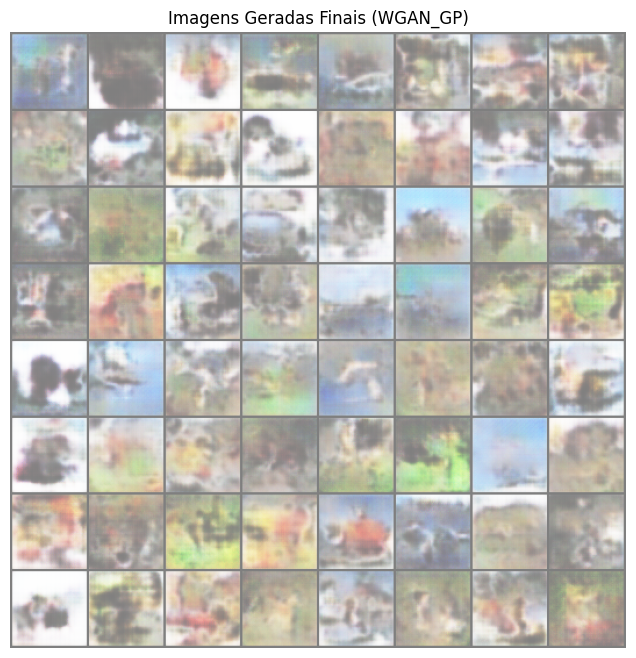

In [109]:
def imshow(img):
    img = img * 0.5 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title(f"Imagens Geradas Finais ({GAN_TYPE})")
imshow(utils.make_grid(fake, padding=2, normalize=True))
plt.show()

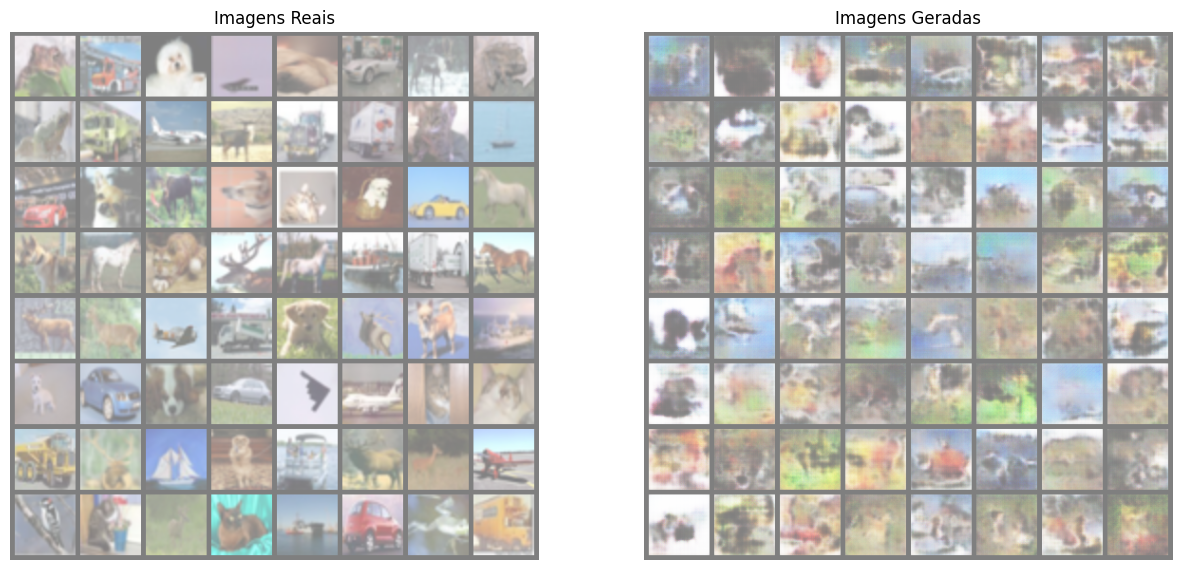

In [110]:
real_batch = next(iter(dataloader)) 
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.axis("off")
plt.title("Imagens Reais")
imshow(utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu())

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Imagens Geradas")
imshow(utils.make_grid(fake, padding=5, normalize=True))

plt.show()